# Предсказание стоимости лечения пациента
В данном [датасете](https://www.kaggle.com/datasets/mirichoi0218/insurance) содержится информация о пациентах некоторой клиники, а также медицинский счет, который был выписан этим пациенам по страхованию.
<br>Наша задача: научиться предсказывать стоимость лечения исходя из информации о пациенте.

Признаки в *insurance.csv*:
- age: Возраст пациента.
- sex: Пол пациента.
- bmi: Индекс массы тела.
- children: Количество детей у пациента.
- smoker: Курящий или нет.
- region: Регион США: северо-западный, северо-восточный, юго-западный, юго-восточный.
- charges: Расходы страховой компании на лечение пациента.

## Исследование и предобработка данных
Загрузим все необходимые модули и взглянем на содержимое нашего датасета:

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

insurance_df = pd.read_csv("insurance.csv")

Изучим датасет

In [19]:
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Имеем **1338** наблюдений и **7** признаков. Признаки совпадают с заявленными на странице датасета. Взглянем на типы данных нашего датасета.

In [20]:
insurance_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Как мы можем заметить, типы также являютя адекватными: количество детей измеряется целочисленно, а пол, регион и курение представлены в виде категориальной переменной, а не числом, потому что тогда было бы проблемно интерпретировать, как аналитики связывали бы число и категорию. Взглянем на значения категориальных переменных.

In [21]:
print(f"Sex: {insurance_df.sex.unique()}")
print(f"Smoker: {insurance_df.smoker.unique()}")
print(f"Region: {insurance_df.region.unique()}")

Sex: ['female' 'male']
Smoker: ['yes' 'no']
Region: ['southwest' 'southeast' 'northwest' 'northeast']


Категориальные переменные имеют адекватные величины. Взглянем на то, какие величины имеют численные переменные

In [22]:
insurance_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Также видим, что каких то выбросов в наших данных нет. Нет людей с возрастом в 100+ лет, людей с неадекватно большим количеством детей или индексом массы тела. В среднем клиентами медицинского центра являются люди возрастом 39 лет и 1 ребенком в семье. Однако исходя из индекса массы тела, в среднем клиенты медицинского страхования имеют ожирение (здоровый ИМТ - от 18 до 25, но средний в датасете - 30.6).

Переведем наши категориальные признаки в численные. Воспользуемся [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html):

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(insurance_df.sex.unique()) # 0 - female, 1 - male
insurance_df.sex = le.transform(insurance_df.sex)

le.fit(insurance_df.smoker.unique()) # 0 - no, 1 - yes
insurance_df.smoker = le.transform(insurance_df.smoker)

le.fit(insurance_df.region.unique())
insurance_df.region = le.transform(insurance_df.region) # 0 - NE, 1 - NW, 2 - SE, 3 - SW

insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


Изучим корреляции между нашими данными. Построим матрицу корреляций.

<Axes: >

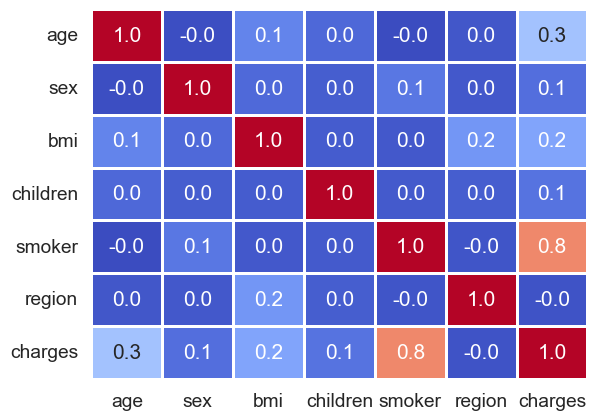

In [42]:
sns.set(font_scale=1.25)
correlations = insurance_df.corr()
sns.heatmap(correlations,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            linewidths=1,
            cbar=False
            )

Уже отсюда можно сделать вывод, что для курящих людей стоимость медицинских услуг будет только расти. Также можно заметить положительную небольшую корреляцию между возрастом и счетом, ИМТ и счетом и ИМТ и регионом. Судя по всему, есть регионы, где число людей с ожирением выше, чем в остальных регионах. Также как мы можем заметить, что зависимость между полом человека и стоимостью его лечения крайне мала, что означает, что никаких дискриминаций нет - возможно эта зависимость возникла в результате несбалансированной выборки, а возможно какой-то из полов действительно больше подвержен каким то серьезным заболеваниям. Например мы можем увидеть слабую завимость между курящим человеком и его полом. Разумеется, пол человека никак не зависит от факта курения, но вот факт курения может зависеть от пола человека, например мужчины могут курить чаще женщин. 

Уже отсюда проясняется характер поведения наших признаков. Однако взглянем еще графически на наши признаки, исследуем, как они зависят друг от друга и как распределены:

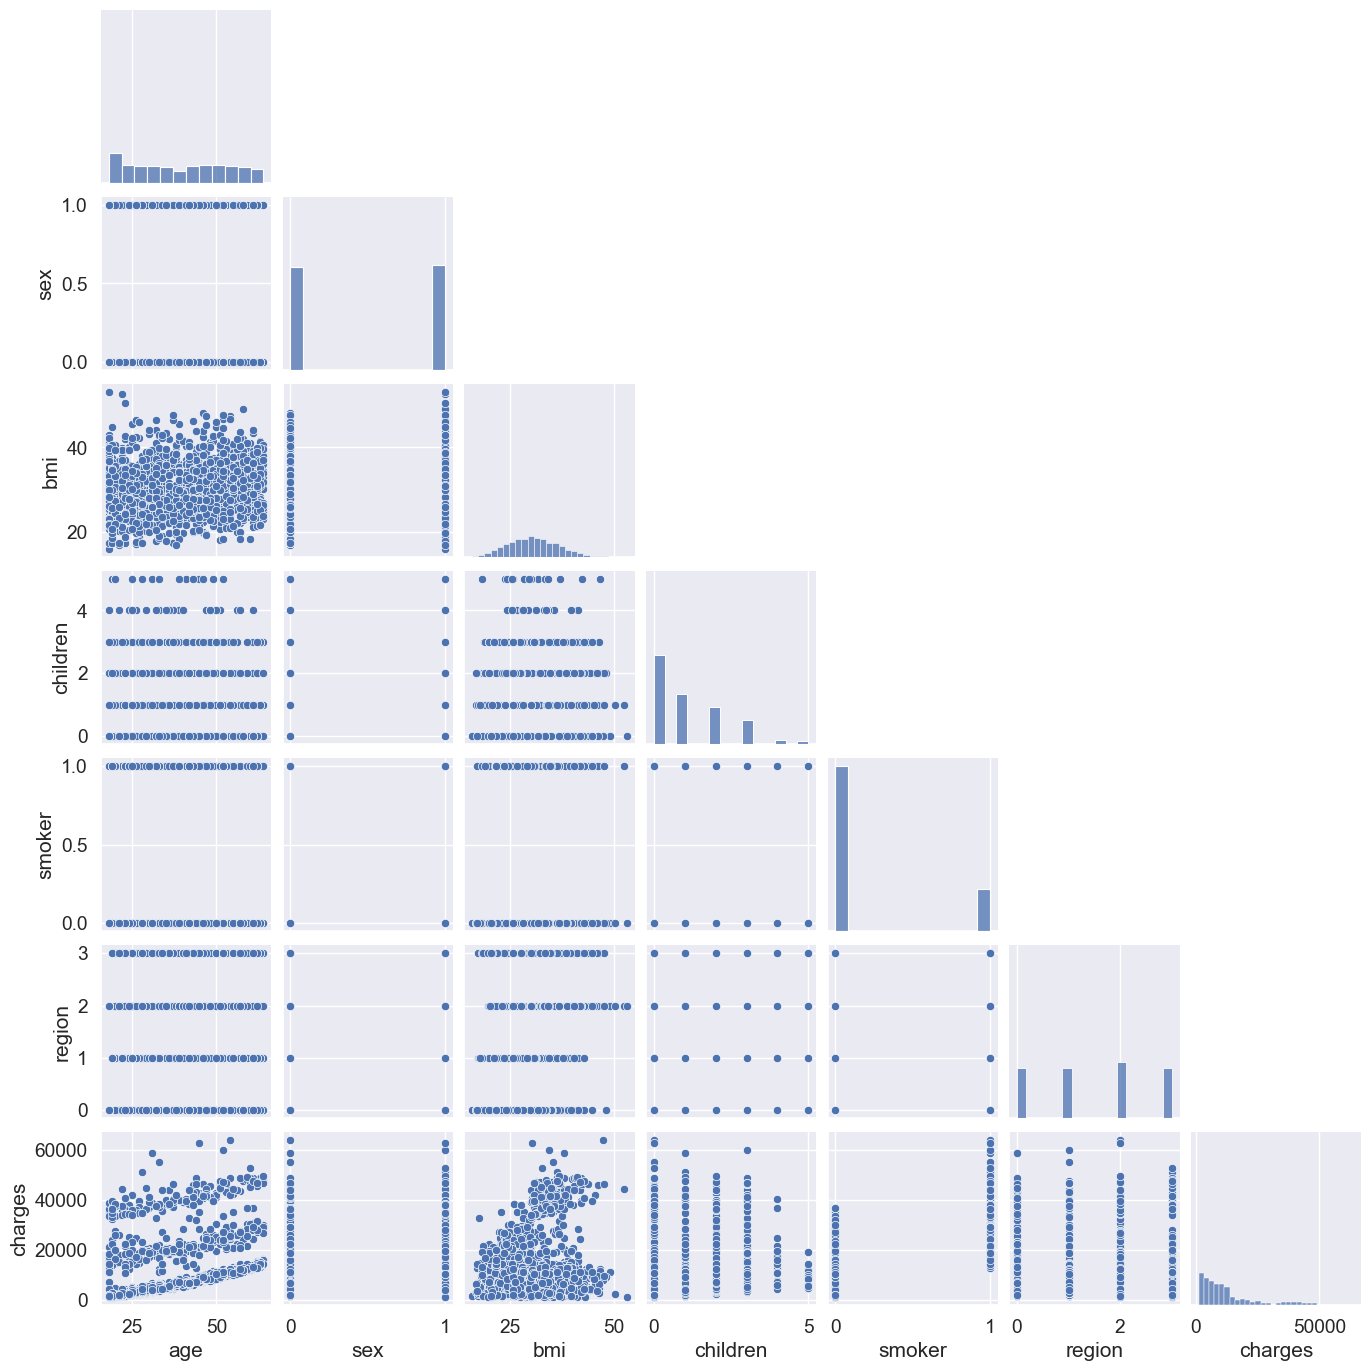

In [44]:
sns.pairplot(data=insurance_df, corner=True, height=2)

На графике можно заметить те же зависимости, что мы и выразили чуть выше (хотя зависимость region ~ charges пока еще не так очевидна).
Исследуем поподробнее зависимость возраста от медицинского счета:

Text(0.5, 1.0, 'Зависимость счета от возраста.')

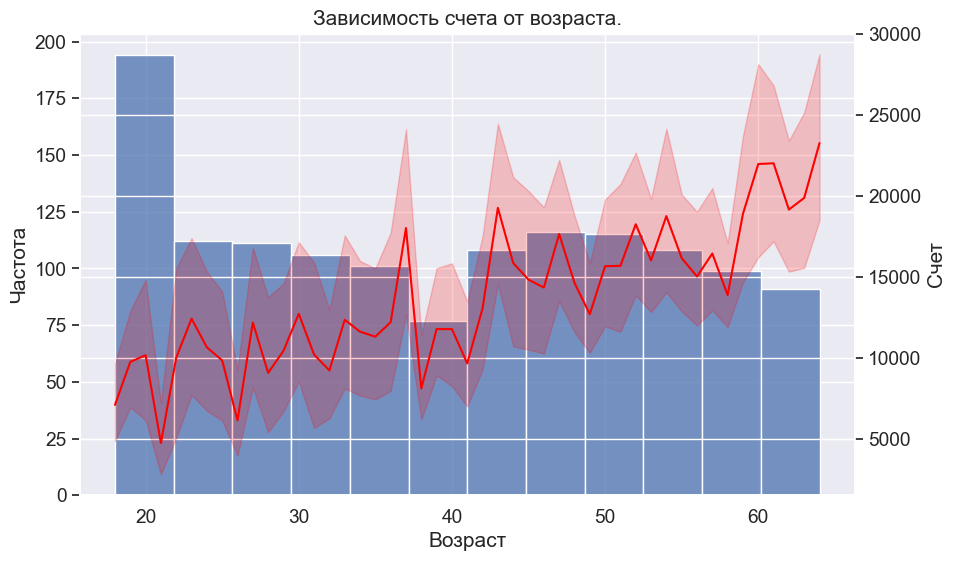

In [53]:
fix, axis_1 = plt.subplots(figsize=(10, 6))
axis_2 = axis_1.twinx() # создадим двойной график - две оси У будут делить одну ось Х

sns.histplot(data=insurance_df, x="age", ax=axis_1, element="bars")

sns.lineplot(data=insurance_df, x="age", y="charges", ax=axis_2, color='red')

axis_1.set_xlabel("Возраст")
axis_1.set_ylabel("Частота")
axis_2.set_ylabel("Счет")
axis_1.set_title("Зависимость счета от возраста.")

Из графика видно, что счет зависит от возраста, причем заметно. Также можем увидеть, что самая большая группа людей по возрасту - это пациенты 18-23 лет.
Теперь изучим зависимость размера счета от ИМТ. Для этого введем дополнительную переменную "obessity", которая будет указывать на то, страдает ли человек от ожирения или нет. В качестве порогового значения выберем величину, заявленную медициной: ИМТ выше 25 указывает на наличие ожирения.

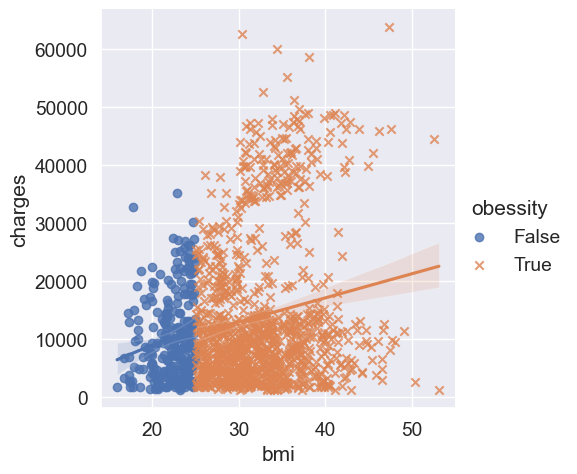

In [61]:
insurance_df["obessity"] = (insurance_df.bmi > 25)

sns.lmplot(data=insurance_df, x="bmi", y="charges", hue="obessity", markers=["o", "x"])

Как мы можем заметить, счет действительно в какой то степени зависит от от ИМТ человека, однако мы можем наблюдать некоторое облако точек сверху над основным облаком точек. Попробуем выяснить, почему оно так сильно отделилось от основного облака. Например, попробуем классифицировать наших пациентов не только по факту ожирения, но и по факту курения.

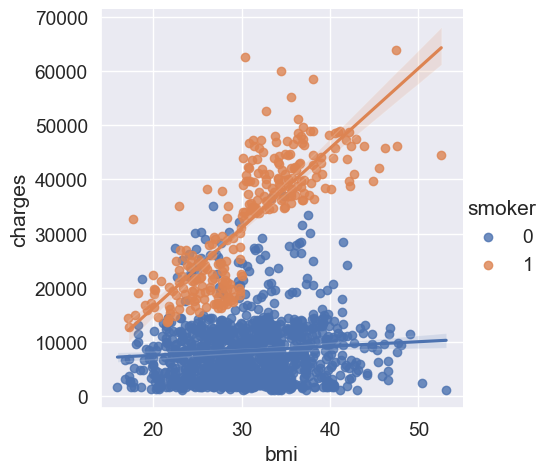

In [64]:
sns.lmplot(data=insurance_df, x="bmi", y="charges", hue="smoker")

И вот теперь картина про влияние ИМТ на счет прояснилась почти полностью. Как можно увидеть из графика выше, ИМТ действительно в некоторой степени влияет на счет. ИМТ имеет малую корреляцию с медсчетом, если пациент не курит, но если пациент и с большим индексом массы тела, и курит, тогда мы можем заявить, что страховые расходы на лечение пациента будут расти разительно вместе с его ИМТ (врядли индекс массы тела зависит от медсчета в больнице. Но на ИМТ могут влиять другие факторы, такие как курение, образ жизни, питание и т.д.)

Взглянем на зависимость размера счета от количества детей, прописанных в медицинском центре.

<Axes: xlabel='children', ylabel='charges'>

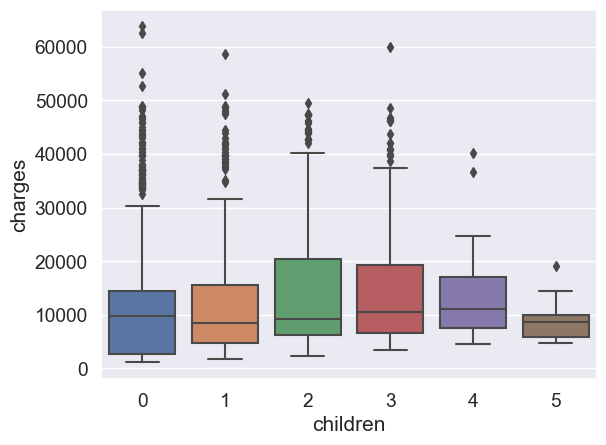

In [65]:
sns.boxplot(data=insurance_df, x="children", y="charges")

Отсюда можно сделать вывод, что при отсутствии детей или будучи членом многодетной семьи, размер расходов будет меньше, чем если бы у пациента было 2 ребенка.

Исследуем взаимосвязь между размером счета и категориальными признаками.

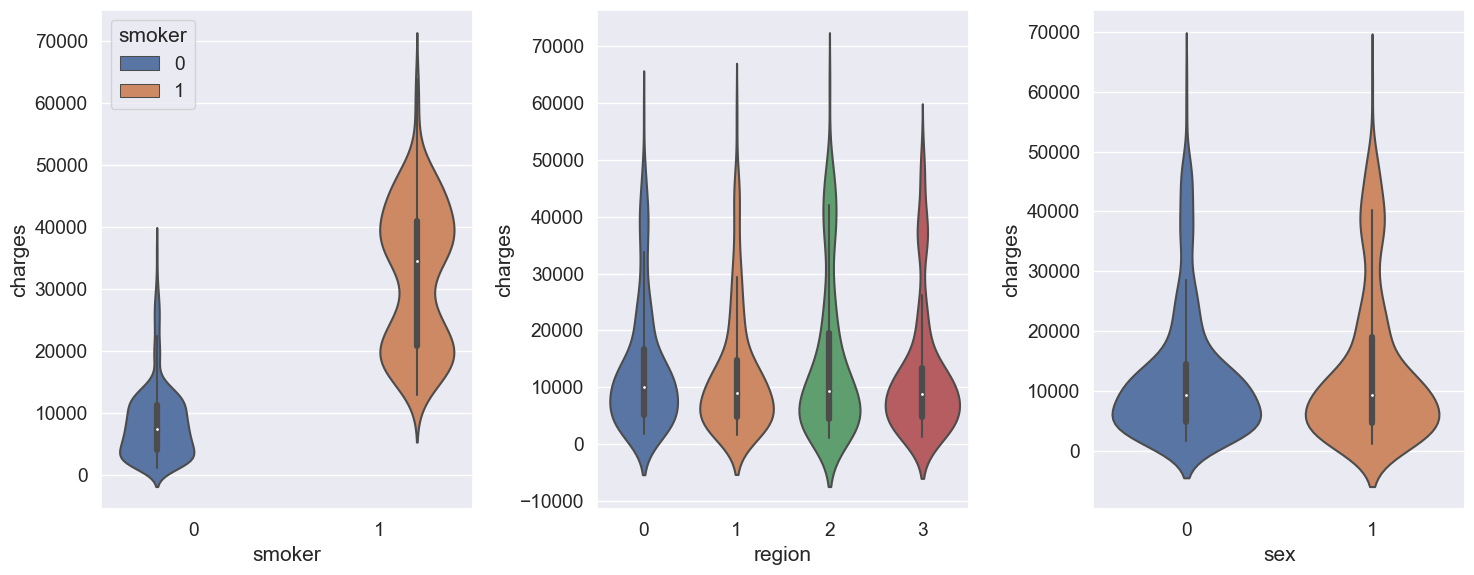

In [66]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,6))
sns.violinplot(data = insurance_df, y = "charges", x = "smoker",hue = "smoker", ax = axes[0])
sns.violinplot(data = insurance_df, y = "charges", x = "region", ax = axes[1])
sns.violinplot(data = insurance_df, y = "charges", x = "sex", ax = axes[2])

plt.tight_layout()

В очередной раз замечаем, что курение вредит вашему страховому кошельку. К тому же, из второго графика видно, что жители SE региона чаще подвержены дорогому медицинскому обслуживанию, как и мужчины, что можно увидеть из третьего графика.

В конце концов, взглянем на зависимость счета от возраста у курящих и некурящих людей.

<Axes: xlabel='age', ylabel='charges'>

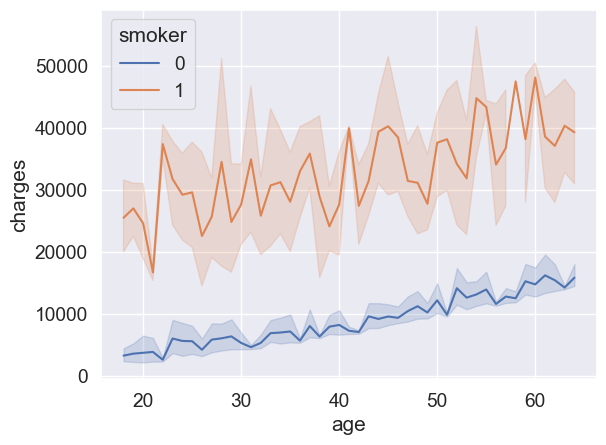

In [67]:
sns.lineplot(data=insurance_df, x="age", y="charges", hue = "smoker")

И мы снова натолкнулись на ту же песню: "Курить - это зло". Также видим, что счет по страхованию растет вместе с возрастом пациента, и это в целом логично - с возрастом у людей все чаще возникают проблемы со здоровьем.

Мы изучили наши данные, выявили все важные зависимости. Теперь мы готовы приступать к обучению модели.

## Обучение модели
Наш датасет имеет непрерывное распределение исследуемого признака, а так же около-линейные зависимости, так что воспользуемся методом линейной регрессии для предсказания размера счета пациента. Применим L1-регуляризацию (Lasso), чтобы занулить вклад переменных, которые не влияют на результат.

In [82]:
X = insurance_df.drop(["charges", "obessity"], axis=1)
y = insurance_df.charges

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

coefficients = lasso_reg.coef_
pd.DataFrame({
    "Parameters": list(X),
    "Coefficients": coefficients
}).set_index("Parameters").T

Parameters,age,sex,bmi,children,smoker,region
Coefficients,252.681944,-281.419063,345.072823,470.935964,24412.907595,-369.437552


Посмотрим на RMSE:

In [83]:
y_pred = lasso_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 6029.473048333077


Получаем, что в среднем ошибка предсказания расходов на лечение равняется ~6000. Достаточно неприятная ошибка, т.к. эта сумма является почти 50% от средней суммы на лечение.

## Анализ модели.
Взглянем на остатки нашей модели.

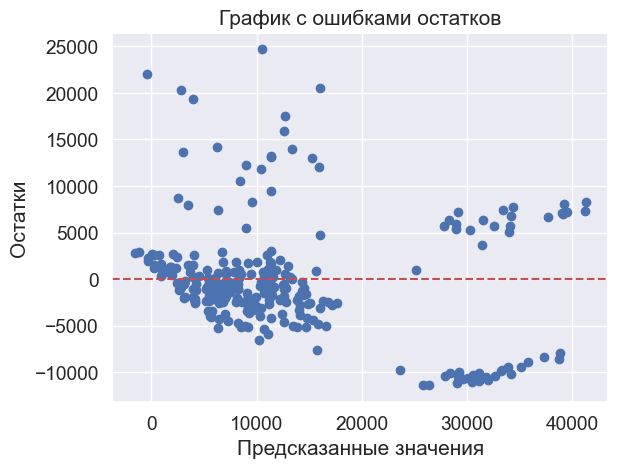

In [85]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График с ошибками остатков')
plt.show()

Как мы видим, поведение остатков нашей модели непостоянно: на каком то промежутке, например в левой половине графика, они не очень велики, а в правой половине - достаточно велики. По хорошему, нам не стоило применять метод линейной регрессии в этими данными. Вероятно стоило произвести некоторые преобразования данных, например применить логарифмическую трансформацию к некоторым признакам.

Нарисуем QQ-plot для распределения остатков.

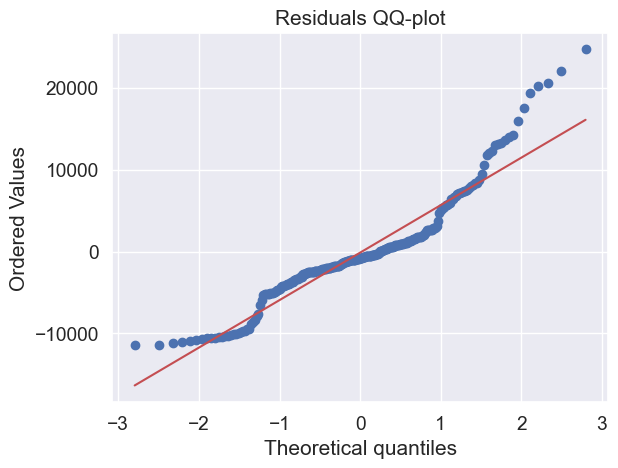

In [91]:
import scipy.stats as stats
stats.probplot(residuals, plot=plt)
plt.title("Residuals QQ-plot")
plt.show()

Местами больше, местами меньше, но в целом в приближении можно заявить о хоть сколько то нормальном распределении остатков, хоть и с натяжкой.

## Итог
В ходе выполнени анализа данных о пациентах и их выставленных счетах для медицинского страхования выяснилось, что существуют зависимости между фактом курения, ИМТ, количеством детей у пациента и его возрастом на расходы страховой компании, но факт курения влияет на расходы в наибольшей степени. 

В данной работе были изучены новые подходы к анализу данных, их визуализации, а также применен на практике один из типовых методов решения задач регрессии - линейная регрессия (с модификацей на L1-регуляризацию)